## Modelling of melt volatile concentrations in porphyry Cu deposits and constraints from apatite compositions
This notebook is supplementary material to the paper "Apatite evidence for a degassing crystal-rich magma reservoir beneath the Quellaveco porphyry copper deposit (Southern Peru)" by Nathwani et al.

### 1. Import libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import lambertw
import periodictable as pt
import math as math
import seaborn as sb
import random as rd
from pylab import rcParams
import matplotlib.cm     as cm
import matplotlib as mpl
from time import sleep
from tqdm.notebook import tqdm
import datashader as ds
import datashader.transfer_functions as tf

# Set random seed
rd.seed(1)

### 2. Define functions and calibrations

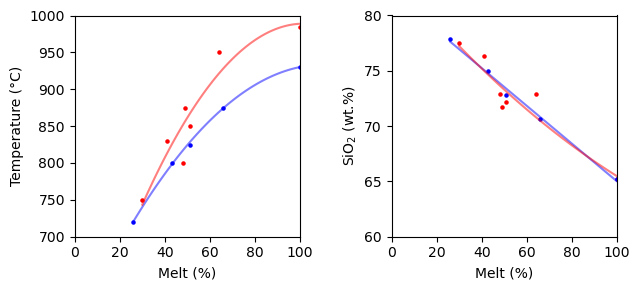

In [47]:
# Calibrate X-T-SiO2 relationship using experiments of Caricchi & BLundy (2015)
# water saturated
car_blu_sat_T = [930,875,825,800,720]
car_blu_sat_m = [100,66,51,43,26]
car_blu_sat_SiO2 = [65.24,70.68,72.80,74.97,77.89]

# Blundy and Caricchi water undersaturated
car_blu_T = pd.Series([750,800,830,850,875,950,985])
car_blu_m = pd.Series([30,48,41,51,49,64,100])
car_blu_SiO2 = pd.Series([77.54,72.93,76.36,72.14,71.76,72.87,65.24])

fig, axs = plt.subplots(1,2, figsize = (6.5,3))

axs[0].scatter(car_blu_m,car_blu_T, s = 5, color = 'r')
axs[0].scatter(car_blu_sat_m,car_blu_sat_T, s = 5, color = 'b')

# Saturated dataset fit 
x_test1 = np.linspace(np.min(car_blu_sat_m), np.max(car_blu_sat_m), 100)
fit1 = np.polyfit(car_blu_sat_m,car_blu_sat_T, 2)
aT = fit1[0] # assign constants
bT = fit1[1]
cT = fit1[2]
fit_equation1 = aT * x_test1**2 + bT * x_test1 + cT                    
y_testT = aT * x_test1**2 + bT * x_test1 + cT
axs[0].plot(x_test1, y_testT,color = 'b',alpha = 0.5)

fit2 = np.polyfit(car_blu_sat_m,car_blu_sat_SiO2, 1)
a2 = fit2[0] # assign constants
b2 = fit2[1]
fit_equation2 =  a2 * x_test1 + b2                  
y_test2 = a2 * x_test1 + b2
axs[1].plot(x_test1, y_test2,color = 'b',alpha = 0.5)

def calc_melt_F_SiO2_trend(SiO2):
    residual = SiO2-np.min(car_blu_sat_SiO2)
    a1, b1, c1 = np.polyfit(car_blu_sat_m,car_blu_sat_SiO2, 2) # fit data
    return(a1, b1, c1)

def calc_melt_SiO2_sat(a1, b1, c1, F):
    y1 =a1 * F**2 + b1 * F**1 + c1 * F**0
    return(y1)

def calc_T_sat(melt_fraction):    
    y = aT * melt_fraction**2 + bT * melt_fraction**1 + cT * melt_fraction**0
    return(y +273.15)


x_test2 = np.linspace(np.min(car_blu_m), np.max(car_blu_m), 100)
fit3 = np.polyfit(car_blu_m,car_blu_T, 2) 
a3 = fit3[0] # assign constants
b3 = fit3[1]
c3 = fit3[2]
# d2 = fit2[3]
fit_equation3 = a3 * x_test2**2 + b3 * x_test2 + c3                    
y_test3 = a3 * x_test2**2 + b3 * x_test2 + c3
axs[0].plot(x_test2, y_test3,color = 'r',alpha = 0.5)

def calc_T_undersat(melt_fraction):    
    y = a2 * melt_fraction**2 + b2 * melt_fraction + c2        
    return(y +273.15)


axs[0].set_xlim([0,100])
axs[0].set_ylim([700,1000])
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_xlabel('Melt (%)')

axs[1].scatter(car_blu_m, car_blu_SiO2,s = 5, color = 'r')
axs[1].scatter(car_blu_sat_m, car_blu_sat_SiO2,s = 5, color = 'b')
fit4 = np.polyfit(car_blu_m, car_blu_SiO2, 2)
a4= fit4[0] # assign constants
b4 = fit4[1]
c4 = fit4[2]
x_test = np.linspace(np.min(car_blu_m), np.max(car_blu_m), 100)
y_test4 = a4 * x_test**2 + b4 * x_test + c4
axs[1].plot(x_test, y_test4,color = 'r',alpha = 0.5)
axs[1].set_ylim([60,80])
axs[1].set_xlim([0,100])
axs[1].set_xlabel('Melt (%)')
axs[1].set_ylabel('$\mathregular{SiO_2 }$ (wt.%)')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('T-X-SiO2_Calibrations.svg', dpi = 1200)

Some other functions...

In [48]:
# Calculate Cl fluid and DCl using Tattich, Chelle-Michou et al.
def calc_Cl_fluid(SiO2, P, Cl_melt):
    a = 0.4078
    b = 0.1456
    c = 34.47
    P0 = 175.8
    D0 = 0.0005862
    term1 = np.exp(a*Cl_melt+b*SiO2)
    term2 = 1 + np.exp((P0-P)/c)
    DCl = D0*(term1/term2)
    Cl_fluid = DCl*Cl_melt
    NaCl_fluid = Cl_fluid*(pt.formula("NaCl").mass/pt.formula("Cl").mass)
    return(NaCl_fluid, DCl)


# Calculate the critical NaCl for a given T after Dreisner and Heinrich (2007)
def calc_critical_XNaCl(T):
    d8 = 7.77761E-2
    d9 = 2.7042E-4
    d10 = -4.244821E-7
    d11 = 2.580872E-10
    X = d8*(T-600)**0 + d9*(T-600)**1 + d10*(T-600)**2 + d11*(T-600)**2
    return(X)

# Loucks (2018) Ti in zircon equation
def T_calc(Ti_zrc, P, aTiO2, aSiO2):
    T_K = (-4800+(0.4748*(P-1000)))/(np.log10(Ti_zrc)-5.5711-np.log10(aTiO2)+np.log10(aSiO2))
    T_C = T_K - 273.15
    return(T_C)

Li and Costa (2020) approach to calculate apatite-melt exchange coefficients

In [49]:
# Using Li and Costa (2020) to calculate distribution coefficients

def calc_melt_halogen(XFAp, XClAp, XOHAp, T):
    R = 8.3145
    T = T + 273.15 # convert to kelvin
    # Activity coefficients
    WClOH = 5000 # Interaction parameters
    WFCl = 16000
    WFOH = 7000
    act_F = np.exp(((XClAp*(1-XFAp)*WFCl+XOHAp*(1-XFAp)*WFOH-(XClAp*XOHAp)*WClOH))/(R*T))
    act_Cl = np.exp(((XOHAp*(1-XClAp)*WClOH+XFAp*(1-XClAp)*WFCl-(XOHAp*XFAp)*WFOH))/(R*T))
    act_OH = np.exp(((XClAp*(1-XOHAp)*WClOH+XFAp*(1-XOHAp)*WFOH-(XClAp*XFAp)*WFCl))/(R*T))
    
    
    # deltaG = a + b*T
    a = 72900
    b = -34
    G_OHCl = a + b*T
    KdOHCl = math.exp(-G_OHCl/(R*T))/(act_OH/act_Cl)
                      
    a = 94600
    b = -40
    G_OHF = a + b*T
    KdOHF = math.exp(-G_OHF/(R*T))/(act_OH/act_F)
    
    KdClF = KdOHF/KdOHCl

    # Calculate ratios in melt
    XFXOHmelt = (XFAp/XOHAp)/(1/KdOHF)
    XClXOHmelt = (XClAp/XOHAp)/(1/KdOHCl)
    XFXClmelt = (XFAp/XClAp)/(1/KdClF)

    return(XFXClmelt, XClXOHmelt, XFXOHmelt, KdOHCl, KdOHF, KdClF)

# Import probe data
probe_data = pd.read_csv('Quellaveco_Apatite_Probe-Copy1.csv')
# Tidy things up
probe_data.drop(probe_data[probe_data['F apfu'] > 2].index, inplace=True)
probe_data.drop(probe_data[probe_data['Cl apfu'] > 2].index, inplace=True)
probe_data.drop(probe_data[probe_data['est OH apfu'] > 2].index, inplace=True)
probe_data['XF'] = probe_data['F apfu']/2
probe_data['XCl'] = probe_data['Cl apfu']/2
probe_data['XH'] = probe_data['est OH apfu']/2
types = [x for _, x in probe_data.groupby('Type')]
units = types[1].groupby('Unit') # Only use inclusions

# Import SIMS data
sims_data = pd.read_csv('220214_Quellaveco_Apatite_SIMS.csv')
sims_data['XCl'] = ((sims_data['35Cl']/3.72)/2)*100
sims_data['XF'] = ((sims_data['19F']/2.00)/2)*100
sims_data['XOH'] = 100-(sims_data['XCl']+sims_data['XF'])

# SIMS March data

sims_data_march = pd.read_csv('Apatite_SIMS_March2022.csv')
sims_data_march['sum'] = (sims_data_march['19F']/18.998)+(sims_data_march['35Cl']/35.450)+(sims_data_march['16OH']/17)
sims_data_march['XF'] = 100*(sims_data_march['19F']/18.998)/sims_data_march['sum']
sims_data_march['XCl'] = 100*(sims_data_march['35Cl']/35.450)/sims_data_march['sum']
sims_data_march['XOH'] = 100*(sims_data_march['16OH']/17)/sims_data_march['sum']


## 3. Import data from this study and calculate melt volatile ratios

In [50]:
colour_dict = {'Toquepala Granodiorite':'mediumorchid','Yarabamba Monzonite':'hotpink',
              'Quellaveco Granodiorite':'pink',
               'Granodiorite Porphyry':'royalblue','Early Porphyry':'navajowhite','Intermineral Monzonite':'orange',
              'Monzodiorite':'firebrick','Late Porphyry':'maroon',
              'Dacite Dyke':'gold'}
shape_dict = {'Toquepala Granodiorite':'s','Yarabamba Monzonite':'v','Quellaveco Granodiorite':'d',
               'Granodiorite Porphyry':'o','Early Porphyry':'o','Intermineral Monzonite':'o',
              'Monzodiorite':'o','Late Porphyry':'o',
              'Dacite Dyke':'o'}




# Import probe data
probe_data = pd.read_csv('Quellaveco_Apatite_Probe-Copy1.csv')
# Tidy things up
probe_data.drop(probe_data[probe_data['F apfu'] > 2].index, inplace=True)
probe_data.drop(probe_data[probe_data['Cl apfu'] > 2].index, inplace=True)
probe_data.drop(probe_data[probe_data['est OH apfu'] > 2].index, inplace=True)
probe_data['XF'] = probe_data['F apfu']/2
probe_data['XCl'] = probe_data['Cl apfu']/2
probe_data['XH'] = probe_data['est OH apfu']/2
types = [x for _, x in probe_data.groupby('Type')]
units_epma = types[1].groupby('Unit') # Only use inclusions

sims_data = pd.read_csv('220214_Quellaveco_Apatite_SIMS.csv')
sims_data['XCl'] = ((sims_data['35Cl']/3.72)/2)
sims_data['XF'] = ((sims_data['19F']/2.00)/2)
sims_data['XH'] = 1-(sims_data['XCl']+sims_data['XF'])
units_sims = sims_data.groupby('Unit') # Only use inclusions

# SIMS March data

sims_data_march = pd.read_csv('Apatite_SIMS_March2022.csv')
sims_data_march['sum'] = (sims_data_march['19F']/18.998)+(sims_data_march['35Cl']/35.450)+(sims_data_march['16OH']/17)
sims_data_march['XF'] = (sims_data_march['19F']/18.998)/sims_data_march['sum']
sims_data_march['XCl'] = (sims_data_march['35Cl']/35.450)/sims_data_march['sum']
sims_data_march['XOH'] = (sims_data_march['16OH']/17)/sims_data_march['sum']
units_sims_march = sims_data_march.groupby('Unit') # Only use inclusions

qvc_zircon = pd.read_csv('QuellavecoZirconMaster.csv')
T_bath = T_calc(qvc_zircon.groupby('Type').get_group('Batholith')['Ti49_ppm'].mean(), 200, 0.7, 1.0)
T_porphyry = T_calc(qvc_zircon.groupby('Type').get_group('Porphyry')['Ti49_ppm'].mean(), 200, 0.7, 1.0)
df_all = []
# Calculate melt vol ratios 
for name1, group in units_epma:
    group = group.reset_index()
    b = 0
    n = 0
    # Adjust temperatures based on unit
    if name1 == 'Yarabamba Monzonite':
        T = T_bath
    elif name1 == 'Toquepala Granodiorite':
        T = T_bath
    else:
        T = T_porphyry
    XFXClmelt_unit = []
    XClXOHmelt_unit = []
    XFXOHmelt_unit = []
    KdClOH_unit = []
    KdFOH_unit = []
    KdClF_unit = []
    for name,i in group.iterrows():
        XFXClmelt, XClXOHmelt, XFXOHmelt, KdClOH, KdFOH, KdClF = calc_melt_halogen(i['XF'], i['XCl'], i['XH'], T)
        XFXClmelt_unit.append(XFXClmelt)
        XClXOHmelt_unit.append(XClXOHmelt)
        XFXOHmelt_unit.append(XFXOHmelt)
        KdClOH_unit.append(KdClOH)
        KdFOH_unit.append(KdFOH)
        KdClF_unit.append(KdClF)
        unit = [name1]*len(group)
        method = ['EPMA']*len(group)
    df = pd.DataFrame(np.column_stack([method, unit, XFXClmelt_unit, XClXOHmelt_unit, XFXOHmelt_unit,
                                      KdClOH_unit, KdFOH_unit, KdClF_unit]),
                      columns = ['Method','Unit', 'XF/XCl','XCl/XOH', 'XF/XOH','KdClOH', 'KdFOH', 'KdClF'])
    df_all.append(df)
    b = b + 1

for name1, group in units_sims:
    group = group.reset_index()
    b = 0
    n = 0
    # Adjust temperatures based on unit
    if name1 == 'Yarabamba Monzonite':
        T = T_bath
    elif name1 == 'Toquepala Granodiorite':
        T = T_bath
    else:
        T = T_porphyry
    XFXClmelt_unit = []
    XClXOHmelt_unit = []
    XFXOHmelt_unit = []
    KdClOH_unit = []
    KdFOH_unit = []
    KdClF_unit = []
    for name,i in group.iterrows():
        XFXClmelt, XClXOHmelt, XFXOHmelt, KdClOH, KdFOH, KdClF = calc_melt_halogen(i['XF'], i['XCl'], i['XH'], T)
        XFXClmelt_unit.append(XFXClmelt)
        XClXOHmelt_unit.append(XClXOHmelt)
        XFXOHmelt_unit.append(XFXOHmelt)
        KdClOH_unit.append(KdClOH)
        KdFOH_unit.append(KdFOH)
        KdClF_unit.append(KdClF)
        unit = [name1]*len(group)
        method = ['SIMS']*len(group)
    df = pd.DataFrame(np.column_stack([method,unit, XFXClmelt_unit, XClXOHmelt_unit, XFXOHmelt_unit,
                                      KdClOH_unit, KdFOH_unit, KdClF_unit]),
                      columns = ['Method','Unit', 'XF/XCl','XCl/XOH', 'XF/XOH','KdClOH', 'KdFOH', 'KdClF'])
    df_all.append(df)
    b = b + 1
    
for name1, group in units_sims_march:
    group = group.reset_index()
    b = 0
    n = 0
    # Adjust temperatures based on unit
    if name1 == 'Yarabamba Monzonite':
        T = T_bath
    elif name1 == 'Toquepala Granodiorite':
        T = T_bath
    else:
        T = T_porphyry
    XFXClmelt_unit = []
    XClXOHmelt_unit = []
    XFXOHmelt_unit = []
    KdClOH_unit = []
    KdFOH_unit = []
    KdClF_unit = []
    for name,i in group.iterrows():
        XFXClmelt, XClXOHmelt, XFXOHmelt, KdClOH, KdFOH, KdClF = calc_melt_halogen(i['XF'], i['XCl'], i['XOH'], T)
        XFXClmelt_unit.append(XFXClmelt)
        XClXOHmelt_unit.append(XClXOHmelt)
        XFXOHmelt_unit.append(XFXOHmelt)
        KdClOH_unit.append(KdClOH)
        KdFOH_unit.append(KdFOH)
        KdClF_unit.append(KdClF)
        unit = [name1]*len(group)
        method = ['SIMS - March']*len(group)
    df = pd.DataFrame(np.column_stack([method,unit, XFXClmelt_unit, XClXOHmelt_unit, XFXOHmelt_unit,
                                      KdClOH_unit, KdFOH_unit, KdClF_unit]),
                      columns = ['Method','Unit', 'XF/XCl','XCl/XOH', 'XF/XOH','KdClOH', 'KdFOH', 'KdClF'])
    df_all.append(df)
    b = b + 1
    
    
df = pd.concat(df_all)
for col in df.iloc[:,2:]:
    df[col] = pd.to_numeric(df[col])

# Filter for only porphyry units
df = df.reset_index(drop = True)
porphyry_data = df.drop(df[(df.Unit == 'Yarabamba Monzonite') | (df.Unit == 'Toquepala Granodiorite') 
                               | (df.Unit == 'Quellaveco Granodiorite')].index)

# Calculate 95% confidence interval for the porphyry apatite inclusions
XFXCl_min = porphyry_data['XF/XCl'].quantile(0.05)
XFXCl_max = porphyry_data['XF/XCl'].quantile(0.95)
XClXOH_min = porphyry_data['XCl/XOH'].quantile(0.05)
XClXOH_max = porphyry_data['XCl/XOH'].quantile(0.95)
XFXOH_min = porphyry_data['XF/XOH'].quantile(0.05)
XFXOH_max = porphyry_data['XF/XOH'].quantile(0.95)

df_epma = df[df.Method == 'EPMA']
df_sims = df[df.Method == 'SIMS']
df_sims_march = df[df.Method == 'SIMS - March']

## 4. Water-saturated Monte Carlo modelling

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


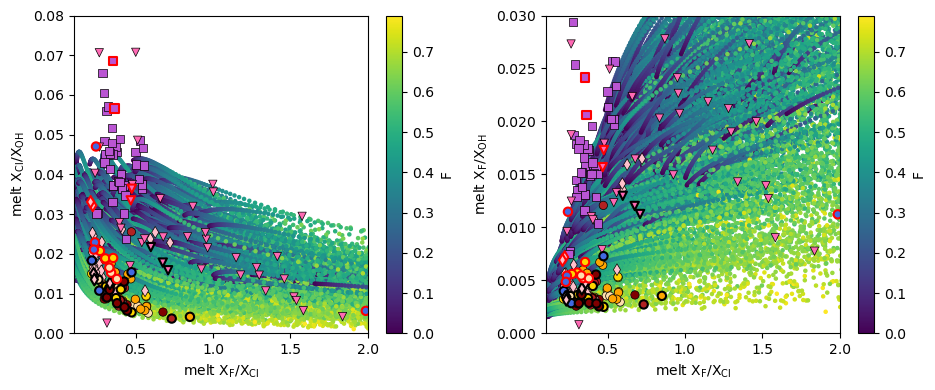

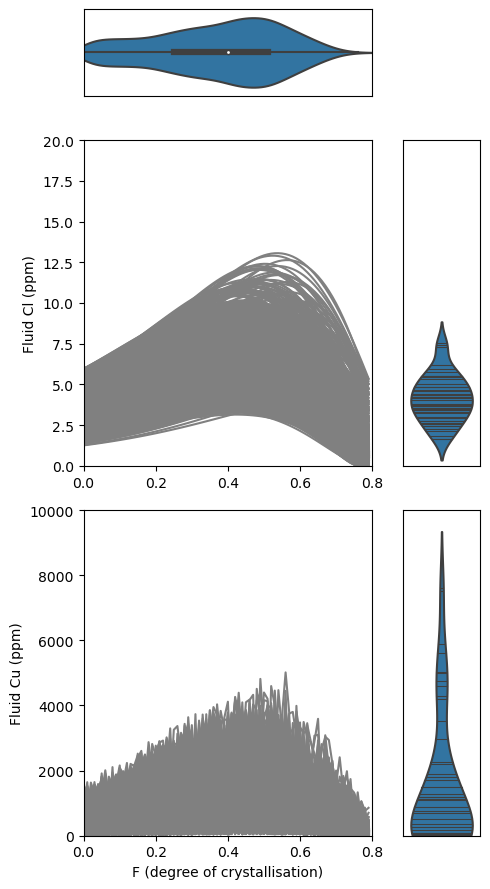

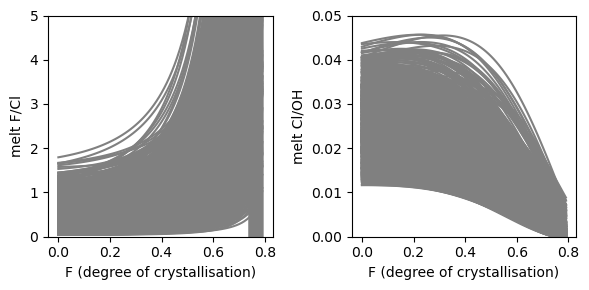

In [51]:
colour_dict = {'Toquepala Granodiorite':'mediumorchid','Yarabamba Monzonite':'hotpink',
              'Quellaveco Granodiorite':'pink',
               'Granodiorite Porphyry':'royalblue','Early Porphyry':'navajowhite','Intermineral Monzonite':'orange',
              'Monzodiorite':'firebrick','Late Porphyry':'maroon',
              'Dacite Dyke':'gold'}
shape_dict = {'Toquepala Granodiorite':'s','Yarabamba Monzonite':'v','Quellaveco Granodiorite':'d',
               'Granodiorite Porphyry':'o','Early Porphyry':'o','Intermineral Monzonite':'o',
              'Monzodiorite':'o','Late Porphyry':'o',
              'Dacite Dyke':'o'}



# Numerical model

# Define parameters
# % Cl at saturation
Cl_sat_min = 0.2
Cl_sat_max = 0.6
range_Cl_sat = np.random.uniform(Cl_sat_min, Cl_sat_max, 100)
# % F at saturation
F_sat_min = 0.01
F_sat_max = 0.2
range_F_sat = np.random.uniform(F_sat_min, F_sat_max, 100)
# H2O at saturation
# H2O_sat_min = 3.9
# H2O_sat_max = 7.3 # Chelle-Michou & Rottier pre-print
# range_H2O_sat = np.random.uniform(H2O_sat_min, H2O_sat_max, 100)

DH2Ominmelt_min = 0.01
DH2Ominmelt_max = 0.3
range_DH2Ominmelt = np.random.uniform(DH2Ominmelt_min, DH2Ominmelt_max, 100)

# SiO2 range = dacite
range_SiO2 = np.random.uniform(64,70,100)

# # Temperature in C
# T_min = 700
# T_max = 900
# range_T = np.random.uniform(T_min, T_max, 100)

# Pressure Mpa
P_min = 200
P_max = 400
range_P = np.random.uniform(P_min, P_max, 100)

DF_min = 0.01
DF_max = 1
range_DF = np.random.uniform(DF_min, DF_max, 100)

melt_density = 2500
gas_molar_volume = 0.018 # for water (molar mass/1)
DClminmelt_min = 0.02
DClminmelt_max = 0.5
range_DClminmelt = np.random.uniform(DClminmelt_min, DClminmelt_max, 100)

DFminmelt_min = 0.15
DFminmelt_max = 0.65
range_DFminmelt = np.random.uniform(DFminmelt_min, DFminmelt_max, 100)

Cu_melt_min = 10
Cu_melt_max = 150 #ppm
range_Cu_melt = np.random.uniform(Cu_melt_min, Cu_melt_max, 100)
DCuminmelt_min = 0.2
DCuminmelt_max = 2
range_DCuminmelt = np.random.uniform(DCuminmelt_min, DCuminmelt_max, 100)

start_crst = 0
end_crst = 0.8
crst_increments = 0.01 # steps in model
monte_carlo_run_total = 1000


monte_carlo_run = 0
fig, axs = plt.subplots(1,2, figsize = [9.5,4])
fig2, axs2 = plt.subplots(3,2, figsize = [5,9],  gridspec_kw={'height_ratios': [0.8,3,3],'width_ratios':[3,0.8]})
fig3, axs3 = plt.subplots(1,2, figsize = [6,3])
axr = axs.ravel()
axr2 = axs2.ravel()
axr3 = axs3.ravel()
fig2.delaxes(axs2[0][1])

# empty arrays to put porphyry matching simulations
Cl_sat_filter = []
F_sat_filter = []
H2O_sat_filter = []
crst_filter = []
SiO2_filter = []
P_filter = []
# empty arrays for non matching simulations
Cl_sat_unfilter = []
F_sat_unfilter = []
H2O_sat_unfilter = []
P_unfilter = []
Cl_fluid_all = []
Cu_fluid_all = []
crst_unfilter = []
SiO2_unfilter = []
pbar = tqdm(total = monte_carlo_run_total)
while monte_carlo_run < monte_carlo_run_total:
    crst = 0
    # initialise empty lists to fill
    Cl_melt_list = []
    F_melt_list = []
    Cl_melt_crst_list = []
    Cl_melt_degas_list = []
    crst_all = []
    SiO2_all = []
    Cl_fluid_list = []
    Cu_fluid_list = []
    # pick parameters randomly from set ranges
    P = rd.choice(range_P)
    Cl_sat = rd.choice(range_Cl_sat)
    H2O_sat =  0.0171948701*P + 2.35551895
    F_sat = rd.choice(range_F_sat)
    DClminmelt = rd.choice(range_DClminmelt)
    DH2Ominmelt = rd.choice(range_DH2Ominmelt)
    DFminmelt = rd.choice(range_DFminmelt)
    DF = rd.choice(range_DF)
    initial_SiO2 = rd.choice(range_SiO2)
    a1, b1, c1 = calc_melt_F_SiO2_trend(initial_SiO2)
    # run model until reaches 60% crystallinity
    while crst < end_crst:
        SiO2 = calc_melt_SiO2_sat(a1, b1, c1,(1-crst)*100)
        if crst == 0: # if this is the first iteration use Cl at saturation
            Cl_melt_prev = Cl_sat
            F_melt_prev = F_sat
        else:
            Cl_melt_prev = Cl_melt_list[-1] # use previous step Cl melt
            F_melt_prev = F_melt_list[-1]
        # Now, carry out model as described in text
        T = calc_T_sat((1-crst)*100) # temperature as a function of crystallinity
        density_vol = (gas_molar_volume*P*10**6)/(T+273.15*8.314) # Popa Eq 9
        NaCl_fluid, DCl = calc_Cl_fluid(SiO2, P, Cl_melt_prev) # Calculate DCl from Tattich et al.
        XNaCl_fluid = (NaCl_fluid/pt.formula("NaCl").mass) / ((NaCl_fluid/pt.formula("NaCl").mass) + ((100-NaCl_fluid)/pt.formula("H2O").mass)) # mole fraction NaCl
        if XNaCl_fluid > calc_critical_XNaCl(T): # is it brine saturated?
            print('saturated', XNaCl_fluid, calc_critical_XNaCl(T-273.15), T)
        Cl_fluid = NaCl_fluid/(pt.formula("NaCl").mass/pt.formula("Cl").mass) # Convert NaCl to Cl
        H2Omelt = H2O_sat/(DH2Ominmelt + (1-crst)*(1-DH2Ominmelt)) # H2O in melt after crystallisation
        H2O_wt_exslv = (H2Omelt-H2O_sat)/100 # mass balance
        H2O_vol_exslv = H2O_wt_exslv/(density_vol/melt_density) # Popa Eq 10 - % vol exsolved water
        m_melt = 1-(H2O_wt_exslv + crst) # volume % of melt - mass balance
        # Calculate bulk DCl for melt and fluid - equation from Tattich et al.
        bulk_DCl = DClminmelt*(1 - (H2O_sat/100)*(100/(100-NaCl_fluid)))+DCl.real*(H2O_sat/100)*(100/(100-NaCl_fluid.real)) # calc bulk D Cl
        bulk_DF = (DFminmelt*(1-(H2O_sat/100)))+(DF*(H2O_sat/100)) # calc bulk D F *****
        Cl_melt = Cl_melt_prev/(bulk_DCl+(m_melt/(m_melt+crst_increments))*(1-bulk_DCl)) # Update Cl melt
        F_melt = F_melt_prev/(bulk_DF+(m_melt/(m_melt+crst_increments))*(1-bulk_DF)) # Update F melt
        melt_molar_mass = 32.5 # Can vary between 32.5 and 36.6 for a rhyolite
        # Calculate Cu in fluid
        Cu_melt = rd.choice(range_Cu_melt)
        XH2O_fluid = 1
        DCu_fluid = 8*(10**4)*(((NaCl_fluid.real/300)**2)*(XH2O_fluid**14))+380*(NaCl_fluid.real/300)+0.8 # Calc DCu using Tattitch & Blundy
        DCuminmelt = rd.choice(range_DCuminmelt)
        bulk_DCu = DCuminmelt*((1-(H2O_sat/100))*(100/(100-NaCl_fluid.real)))+DCu_fluid*(H2O_sat/100)*(100/(100-NaCl_fluid.real)) # calc bulk D Cu
        Cu_fluid = bulk_DCu*Cu_melt # in ppm                      
        Cl_melt_list.append(Cl_melt)
        Cl_fluid_list.append(Cl_fluid.real)
        Cu_fluid_list.append(Cu_fluid)
        F_melt_list.append(F_melt)
        crst_all.append(crst)
        SiO2_all.append(SiO2)
        crst = crst + crst_increments # next increment
    # convert conc to mol
    mol_Cl =  [i/pt.formula("Cl").mass/(100/melt_molar_mass) for i in Cl_melt_list] 
    mol_F =  [i/pt.formula("F").mass/(100/melt_molar_mass) for i in F_melt_list]
    H2O_melt = np.empty(len(mol_Cl))
    H2O_melt.fill(H2O_sat)

    # Calculate moles of H2O using Zhang et al. 2012
    mol_H2O_melt = (H2O_melt/pt.formula("H2O").mass)/((H2O_melt/pt.formula("H2O").mass)+((100-H2O_melt)/melt_molar_mass))

    # equilibrium constant lnK = a + bK for H2O disassociation
    K2 = rd.choice(np.random.uniform(0.44, 0.52, 100))
    # calculate XOH using Li and Hermann 2015:
    mol_OH_melt = (0.5-np.sqrt(0.25-(((K2-4)/K2)*(mol_H2O_melt-mol_H2O_melt**2))))/((K2-4)/(2*K2))
    
    #calc ratios
    FCl_ratio = np.divide(mol_F,mol_Cl)
    ClOH_ratio = np.divide(mol_Cl,mol_OH_melt)
    FOH_ratio = np.divide(mol_F,mol_OH_melt)
    
    # Filter for values that are within the porphyry range
    FCl_filter = np.any(np.where((FCl_ratio > XFXCl_min) & (FCl_ratio < XFXCl_max),
                          True, False))
    ClOH_filter = np.any(np.where((ClOH_ratio > XClXOH_min) & (ClOH_ratio < XClXOH_max),
                          True, False))
    FOH_filter = np.any(np.where((FOH_ratio > XFXOH_min) & (FOH_ratio < XFXOH_max),
                          True, False))
    if FCl_filter == True and ClOH_filter == True and FOH_filter == True:
        Cl_sat_filter.append(Cl_sat)
        F_sat_filter.append(F_sat)
        H2O_sat_filter.append(H2O_sat)
        P_filter.append(P)
    # else:
    Cl_sat_unfilter.append(Cl_sat)
    F_sat_unfilter.append(F_sat)
    H2O_sat_unfilter.append(H2O_sat)
    P_unfilter.append(P)
    
    Cl_fluid_all.append(Cl_fluid_list)
    Cu_fluid_all.append(Cu_fluid_list)
    
    # try to filter for crystallisation 
    fil1 = np.where((FCl_ratio > XFXCl_min) & (FCl_ratio < XFXCl_max),True, False)
    fil2 = np.where((ClOH_ratio > XClXOH_min) & (ClOH_ratio < XClXOH_max),True, False)
    fil3 = np.where((FOH_ratio > XFXOH_min) & (FOH_ratio < XFXOH_max),True, False)
    filtotal = np.where((fil1==True)&(fil2==True)&(fil3==True), True, False)
    
    if np.any(filtotal):
        index = np.argwhere(filtotal==True).flatten()
        crst_filter.append(np.array(crst_all)[index].flatten())
        SiO2_filter.append(np.array(SiO2_all)[index].flatten())
    # else:
    index = np.argwhere(filtotal==False).flatten()
    crst_unfilter.append(np.array(crst_all)[index].flatten())
    SiO2_unfilter.append(np.array(SiO2_all)[index].flatten())
    
    axr3[0].plot(crst_all, FCl_ratio, 'grey')
    axr3[1].plot(crst_all, ClOH_ratio, 'grey')
    axr[0].scatter(FCl_ratio,ClOH_ratio, c = crst_all, cmap = 'viridis', s = 5)
    axr[1].scatter(FCl_ratio,FOH_ratio, c = crst_all, cmap = 'viridis', s = 5)
    axr2[2].plot(crst_all, Cl_fluid_list, 'grey')
    axr2[4].plot(crst_all, Cu_fluid_list, 'grey')    
    # Prepare for next simulation
    monte_carlo_run = monte_carlo_run + 1
    pbar.update(1)

#Plot resukts
sb.scatterplot(x=df_epma['XF/XCl'], y = df_epma['XCl/XOH'], data = df_epma, ax = axr[0], 
               hue = df_epma['Unit'],style = df_epma['Unit'], 
               palette = colour_dict, markers = shape_dict, legend = False, linewidth = 0.5, edgecolor = 'black')

sb.scatterplot(x=df_epma['XF/XCl'], y = df_epma['XF/XOH'], data = df_epma, ax = axr[1], 
               hue = df_epma['Unit'],style = df_epma['Unit'], 
               palette = colour_dict, markers = shape_dict, legend = False, linewidth = 0.5, edgecolor = 'black')
sb.scatterplot(x=df_sims['XF/XCl'], y = df_sims['XCl/XOH'], data = df_sims, ax = axr[0], 
               hue = df_sims['Unit'],style = df_sims['Unit'],
               palette = colour_dict, markers = shape_dict, legend = False, linewidth = 1.5, edgecolor = 'black')

sb.scatterplot(x=df_sims['XF/XCl'], y = df_sims['XF/XOH'], data = df_sims, ax = axr[1], 
               hue = df_sims['Unit'],style = df_sims['Unit'],
               palette = colour_dict, markers = shape_dict, legend = False, linewidth = 1.5, edgecolor = 'black')
sb.scatterplot(x=df_sims_march['XF/XCl'], y = df_sims_march['XCl/XOH'], data = df_sims_march, ax = axr[0], 
               hue = df_sims_march['Unit'],style = df_sims_march['Unit'],
               palette = colour_dict, markers = shape_dict, legend = False, linewidth = 1.5, edgecolor = 'red')
sb.scatterplot(x=df_sims_march['XF/XCl'], y = df_sims_march['XF/XOH'], data = df_sims_march, ax = axr[1], 
               hue = df_sims_march['Unit'],style = df_sims_march['Unit'],
               palette = colour_dict, markers = shape_dict, legend = False, linewidth = 1.5, edgecolor = 'red')


crst_filter_all = np.concatenate(crst_filter).ravel()
sb.violinplot(crst_filter_all, ax = axr2[0])
axr2[0].set_xlim([0,0.8])

# Plot on fluid compositions
fluids = pd.read_csv('ID_Fluids.csv', encoding='latin-1')
fluids['Cu'].values[fluids['Cu'] > 10000] = 0
sb.violinplot(y = fluids['Cu'], bins = 100, ax = axr2[5], inner="stick")

fluids['NaClequiv'] = fluids['NaClequiv'].apply(pd.to_numeric, args=('coerce',))
fluids['NaClequiv'].values[fluids['NaClequiv'] > 30] = 0

sb.violinplot(y = fluids['NaClequiv']/(pt.formula("NaCl").mass/pt.formula("Cl").mass), ax = axr2[3], inner="stick")

axr3[0].set_ylabel('melt F/Cl')
axr3[0].set_xlabel('F (degree of crystallisation)')
axr[0].set_ylabel('melt $\mathregular{X_{Cl}}$/$\mathregular{X_{OH}}$')
axr[0].set_xlabel('melt $\mathregular{X_{F}}$/$\mathregular{X_{Cl}}$')
axr[1].set_xlabel('melt $\mathregular{X_{F}}$/$\mathregular{X_{Cl}}$')
axr[1].set_ylabel('melt $\mathregular{X_{F}}$/$\mathregular{X_{OH}}$')
axr3[1].set_ylabel('melt Cl/OH')
axr3[1].set_xlabel('F (degree of crystallisation)')
axr[0].set_ylim([0,0.08])
axr[0].set_xlim([0.1,2])
axr[1].set_xlim([0.1,2])
axr[1].set_ylim([0,0.03])
axr2[1].set_yscale('log')
axr2[2].set_ylabel('Fluid Cl (ppm)')
axr2[4].set_ylabel('Fluid Cu (ppm)')
axr2[3].set_ylabel('')
axr2[5].set_ylabel('')
axr2[4].set_xlabel('F (degree of crystallisation)')
axr2[0].set_xlim([0,0.8])
axr2[2].set_xlim([0,0.8])
axr2[4].set_xlim([0,0.8])
axr2[2].set_ylim([0,20])
axr2[3].set_ylim([0,20])
axr2[4].set_ylim([0,10000])
axr2[5].set_ylim([0,10000])
axr2[0].set_xticks([])
axr2[0].set_yticks([])
axr2[3].set_xticks([])
axr2[3].set_yticks([])
axr2[5].set_xticks([])
axr2[5].set_yticks([])
axr3[1].set_ylim([0,0.05])
axr3[0].set_ylim([0,5])
cbar = fig.colorbar(ax=axr[0], mappable = axr[0].collections[0])
cbar.ax.set_ylabel('F', rotation=90)
cbar = fig.colorbar(ax=axr[1], mappable = axr[1].collections[0])
cbar.ax.set_ylabel('F', rotation=90)
fig.tight_layout()
fig2.tight_layout()
fig3.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig('230131_DegassingModel_symbols.svg', dpi = 1200)
plt.rcParams['svg.fonttype'] = 'none'
fig2.savefig('220712_ModelledClandCu.svg', dpi = 1200)
plt.rcParams['svg.fonttype'] = 'none'
fig3.savefig('220211_FluidTrends.svg', dpi = 1200)
plt.show()
pbar.close()


Example of calculating the prob density diagrams in the ms using datashader

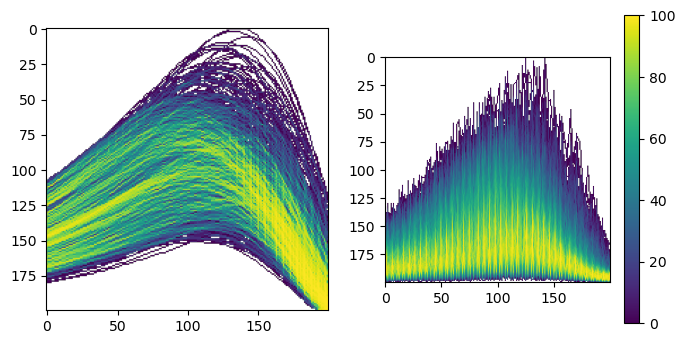

In [52]:
from datashader.utils import export_image

fig, axs = plt.subplots(1,2, figsize = (8,4))

Cl_fluid_all_df = pd.DataFrame(Cl_fluid_all)
Cl_fluid_all_df = Cl_fluid_all_df.clip(lower=0, upper = 500)
points = len(Cl_fluid_all_df.columns)
time = np.linspace(0, 0.8, points)

cvs = ds.Canvas(plot_height=200, plot_width=200)

agg = cvs.line(Cl_fluid_all_df, x=time, y=list(range(points)), agg=ds.count(), axis=1)
img = tf.shade(agg, how='eq_hist', cmap=plt.cm.viridis)
# axs[0].set_ylim([200,0])
# axs[0].set_xlim([190,200])
axs[0].imshow(img.to_pil())
export_image(img, "out", background="black", export_path=".")
Cu_fluid_all_df = pd.DataFrame(Cu_fluid_all)
Cu_fluid_all_df = Cu_fluid_all_df.clip(lower=0, upper = 4700)
points = len(Cu_fluid_all_df.columns)
time = np.linspace(0, 0.8, points)


agg = cvs.line(Cu_fluid_all_df, x=time, y=list(range(points)), agg=ds.count(), axis=1)
img = tf.shade(agg, how='eq_hist', cmap=plt.cm.viridis)
axs[1].imshow(img.to_pil())

import matplotlib as mpl
N  = 999
cmap = plt.get_cmap('viridis',N)
norm = mpl.colors.Normalize(vmin=0,vmax=100)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm)


Calculated "successful" and "unsuccessful" model simulations and plot input conditions as histograms

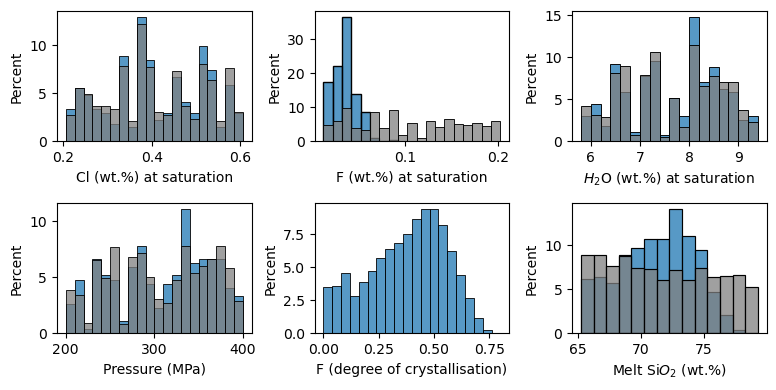

In [53]:

fig, axs = plt.subplots(2,3, figsize = (8,4))

sb.histplot(Cl_sat_filter, stat = 'percent', binwidth = 0.02, color = 'tab:blue', ax = axs[0,0])
sb.histplot(Cl_sat_unfilter, stat = 'percent', binwidth = 0.02, color = 'grey', ax = axs[0,0])
axs[0,0].set_xlabel('Cl (wt.%) at saturation')

sb.histplot(F_sat_filter, stat = 'percent', binwidth = 0.01, color = 'tab:blue', ax = axs[0,1])
sb.histplot(F_sat_unfilter, stat = 'percent', binwidth = 0.01, color = 'grey', ax = axs[0,1])
axs[0,1].set_xlabel('F (wt.%) at saturation')


# sb.histplot(np.concatenate(crst_unfilter).ravel(), stat = 'percent', binwidth = 0.05, color = 'tab:orange', ax = axs[0,1], legend = False)

sb.histplot(H2O_sat_filter, stat = 'percent', binwidth = 0.2, color = 'tab:blue', ax = axs[0,2])
sb.histplot(H2O_sat_unfilter, stat = 'percent', binwidth = 0.2, color = 'grey', ax = axs[0,2])
axs[0,2].set_xlabel('$H_{2}$O (wt.%) at saturation')


sb.histplot(P_filter, stat = 'percent', binwidth = 10, color = 'tab:blue', ax = axs[1,0])
sb.histplot(P_unfilter, stat = 'percent', binwidth = 10, color = 'grey', ax = axs[1,0])
axs[1,0].set_xlabel('Pressure (MPa)')


sb.histplot(np.concatenate(crst_filter).ravel(), stat = 'percent', binwidth = 0.04, color = 'tab:blue', ax = axs[1,1], legend = False)
axs[1,1].set_xlabel('F (degree of crystallisation)')


sb.histplot(np.concatenate(SiO2_filter).ravel(), stat = 'percent', binwidth = 1, color = 'tab:blue', ax = axs[1,2], legend = False)
sb.histplot(np.concatenate(SiO2_unfilter).ravel(), stat = 'percent', binwidth = 1, color = 'grey', ax = axs[1,2], legend = False)
axs[1,2].set_xlabel('Melt Si$O_{2}$ (wt.%)')


plt.tight_layout()
plt.savefig('Model_Histograms.svg', dpi = 1200)
plt.show()

## 5. Water-undersaturated model

  0%|          | 0/1000 [00:00<?, ?it/s]

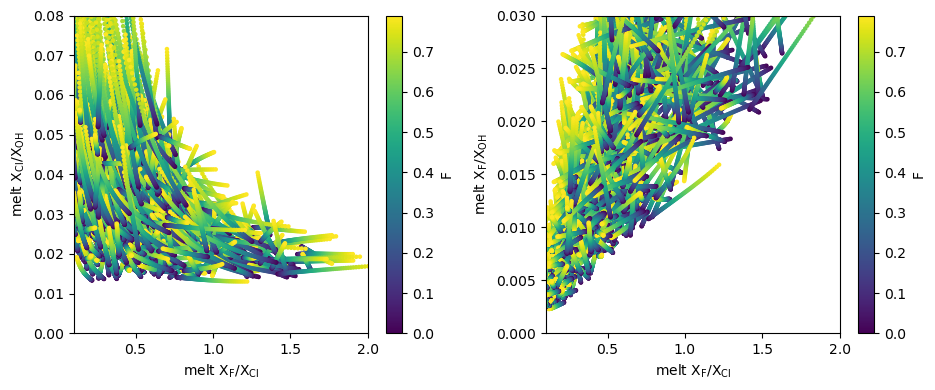

In [54]:
colour_dict = {'Toquepala Granodiorite':'mediumorchid','Yarabamba Monzonite':'hotpink',
              'Quellaveco Granodiorite':'pink',
               'Granodiorite Porphyry':'royalblue','Early Porphyry':'navajowhite','Intermineral Monzonite':'orange',
              'Monzodiorite':'firebrick','Late Porphyry':'maroon',
              'Dacite Dyke':'gold'}
shape_dict = {'Toquepala Granodiorite':'s','Yarabamba Monzonite':'v','Quellaveco Granodiorite':'d',
               'Granodiorite Porphyry':'o','Early Porphyry':'o','Intermineral Monzonite':'o',
              'Monzodiorite':'o','Late Porphyry':'o',
              'Dacite Dyke':'o'}


# Numerical model

# Define parameters
# % Cl at saturation
Cl_min = 0.2
Cl_max = 0.6
range_Cl = np.random.uniform(Cl_min, Cl_max, 100)
# % F at saturation
F_min = 0.01
F_max = 0.2
range_F = np.random.uniform(F_min, F_max, 100)
# H2O at saturation
H2O_min = 3.9
H2O_max = 7.3 # Chelle-Michou & Rottier pre-print
range_H2O = np.random.uniform(H2O_min, H2O_max, 100)

DH2Ominmelt_min = 0.01
DH2Ominmelt_max = 0.3
range_DH2Ominmelt = np.random.uniform(DH2Ominmelt_min, DH2Ominmelt_max, 100)

# SiO2 range = dacite
range_SiO2 = np.random.uniform(64,70,100)


# Pressure Mpa
P_min = 200
P_max = 400
range_P = np.random.uniform(P_min, P_max, 100)

# Experiments have
# determined that the partition coefficient for the distribution
# of F between aqueous or saline fluids and silicate melts
# (DFfl/mt) should be <0.1 at 200–500 MPa (Webster and Holloway, 1990; Webster, 1990).
# Going to allow DF to vary between 0.01 and 0.5 for now (fluid/melt)
DF_min = 0.01
DF_max = 0.1
range_DF = np.random.uniform(DF_min, DF_max, 100)

melt_density = 2500
gas_molar_volume = 0.018 # for water (molar mass/1)
DClminmelt_min = 0.02
DClminmelt_max = 0.5
range_DClminmelt = np.random.uniform(DClminmelt_min, DClminmelt_max, 100)

DFminmelt_min = 0.15
DFminmelt_max = 0.65
range_DFminmelt = np.random.uniform(DFminmelt_min, DFminmelt_max, 100)

Cu_melt_min = 10
Cu_melt_max = 150 #ppm
range_Cu_melt = np.random.uniform(Cu_melt_min, Cu_melt_max, 100)
DCuminmelt_min = 0.2
DCuminmelt_max = 2
range_DCuminmelt = np.random.uniform(DCuminmelt_min, DCuminmelt_max, 100)

start_crst = 0
end_crst = 0.8
crst_increments = 0.01 # steps in model
monte_carlo_run_total = 1000
monte_carlo_run = 0
fig1, axs1 = plt.subplots(1,2, figsize = [9.5,4])
axr1 = axs1.ravel()


pbar = tqdm(total = monte_carlo_run_total)
while monte_carlo_run < monte_carlo_run_total:
    crst = 0
    # initialise empty lists to fill
    Cl_melt_list = []
    F_melt_list = []
    H2O_melt_list = []
    Cl_melt_crst_list = []
    Cl_melt_degas_list = []
    crst_all = []
    # pick parameters randomly from set ranges
    P = rd.choice(range_P)
    Cl_start = rd.choice(range_Cl)
    H2O_start =  rd.choice(range_H2O)
    F_start = rd.choice(range_F)
    DClminmelt = rd.choice(range_DClminmelt)
    DFminmelt = rd.choice(range_DFminmelt)
    DH2Ominmelt = rd.choice(range_DH2Ominmelt)
    initial_SiO2 = rd.choice(range_SiO2)
    a1, b1, c1 = calc_melt_F_SiO2_trend(initial_SiO2)
    # run model until reaches 60% crystallinity
    while crst < end_crst:
        SiO2 = calc_melt_SiO2_sat(a1, b1, c1,(1-crst)*100)
        T = calc_T_sat((1-crst)*100) # temperature as a function of crystallinity
        H2Omelt = H2O_start/(DH2Ominmelt + (1-crst)*(1-DH2Ominmelt)) # H2O in melt after crystallisation
        Cl_melt = Cl_start/(DClminmelt + (1-crst)*(1-DClminmelt)) # H2O in melt after crystallisation
        F_melt = F_start/(DFminmelt + (1-crst)*(1-DFminmelt)) # H2O in melt after crystallisation
        melt_molar_mass = 32.5 # Can vary between 32.5 and 36.6 for a rhyolite
        Cl_melt_list.append(Cl_melt)
        F_melt_list.append(F_melt)
        H2O_melt_list.append(H2Omelt)
        crst_all.append(crst)
        crst = crst + crst_increments # next increment

    mol_Cl =  [i/pt.formula("Cl").mass/(100/melt_molar_mass) for i in Cl_melt_list]
    mol_F =  [i/pt.formula("F").mass/(100/melt_molar_mass) for i in F_melt_list]

    # Calculate moles of H2O using Zhang et al. 2012
    H2O_melt_list = np.array(H2O_melt_list)
    mol_H2O_melt = (H2O_melt_list/pt.formula("H2O").mass)/((H2O_melt_list/pt.formula("H2O").mass)+((100-H2O_melt_list)/melt_molar_mass))

    # equilibrium constant lnK = a + bK for H2O disassociation
    K2 = rd.choice(np.random.uniform(0.44, 0.52, 100)) # varies between 0.44 and 0.52 for dacitic to rhyolitic melts
    # calculate XOH using Li and Hermann 2015:
    mol_OH_melt = (0.5-np.sqrt(0.25-(((K2-4)/K2)*(mol_H2O_melt-mol_H2O_melt**2))))/((K2-4)/(2*K2))

    FCl_ratio = np.divide(mol_F,mol_Cl)
    ClOH_ratio = np.divide(mol_Cl, mol_OH_melt)
    FOH_ratio = np.divide(mol_F, mol_OH_melt)

    # axr[4].plot(crst_all, FOH_ratio, 'grey')
    axr1[0].scatter(FCl_ratio,ClOH_ratio, c = crst_all, cmap = 'viridis', s = 5)
    axr1[1].scatter(FCl_ratio,FOH_ratio, c = crst_all, cmap = 'viridis', s = 5)
    monte_carlo_run = monte_carlo_run + 1
    pbar.update(1)
    

axr1[0].set_ylabel('melt $\mathregular{X_{Cl}}$/$\mathregular{X_{OH}}$')
axr1[0].set_xlabel('melt $\mathregular{X_{F}}$/$\mathregular{X_{Cl}}$')
axr1[1].set_xlabel('melt $\mathregular{X_{F}}$/$\mathregular{X_{Cl}}$')
axr1[1].set_ylabel('melt $\mathregular{X_{F}}$/$\mathregular{X_{OH}}$')
axr1[0].set_ylim([0,0.08])
axr1[1].set_ylim([0,0.03])
axr1[0].set_xlim([0.1,2])
axr1[1].set_xlim([0.1,2])
cbar = fig1.colorbar(ax=axr1[0], mappable = axr1[0].collections[0])
cbar.ax.set_ylabel('F', rotation=90)
cbar = fig1.colorbar(ax=axr1[1], mappable = axr1[1].collections[0])
cbar.ax.set_ylabel('F', rotation=90)
fig1.tight_layout()
plt.savefig('Volatile_undersaturated_model.png', dpi = 1200)
plt.show()